In [1]:
import sys
import os
if sys.platform == "win32":
    os.add_dll_directory(os.path.abspath('') + "/../")
sys.path.insert(0, os.path.abspath('') + "/../")
import resorting_cpp

In [4]:
import random
import numpy as np

total_side_length = 40
filled_length = 26
state_array = np.ndarray((total_side_length,total_side_length),dtype=bool)

for i in range(total_side_length):
    for j in range(total_side_length):
        state_array[i,j] = random.random() > 0.5
filled_shape = np.array([filled_length,filled_length],np.int32)

state_array_copy = state_array.copy()

moves = resorting_cpp.sortSequentiallyByRow(state_array, filled_shape)
print(len(moves))

AttributeError: module 'resorting_cpp' has no attribute 'lib'

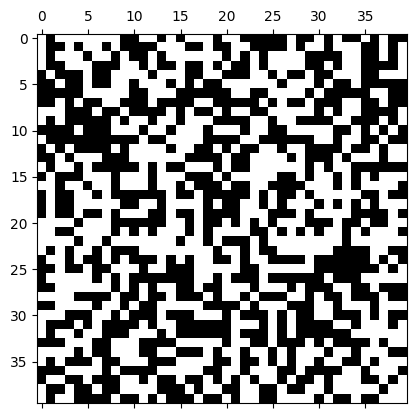

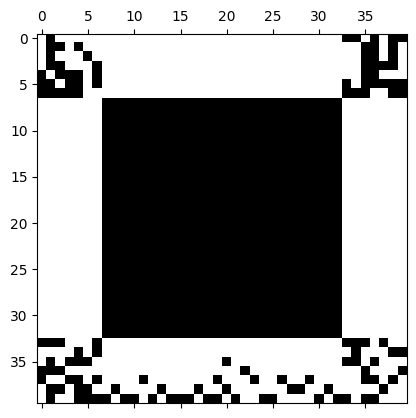

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mplcolors

# Visualization
moveIndex = 0
moveCount = 0

levels = [0, 1, 2, 3, 4]
colors = ['white', 'black', 'green', 'red']
cmap, norm = mplcolors.from_levels_and_colors(levels, colors)

state_array_backup = state_array_copy.copy()

fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
plt.show()
for move in moves:
    if move.xDir != 0:
        for xtmp in range(move.x + move.xDir, move.x, -np.sign(move.xDir)):
            if(state_array_copy[move.y,xtmp]):
                print("Atom in movement path at " + str(xtmp) + "/" + str(move.y))
    else:
        for ytmp in range(move.y + move.yDir, move.y, -np.sign(move.yDir)):
            if(state_array_copy[ytmp,move.x]):
                print("Atom in movement path at " + str(move.x) + "/" + str(ytmp))
    if not state_array_copy[move.y,move.x]:
        print("Starting location not filled")
    state_array_copy[move.y,move.x] = 0
    state_array_copy[move.y + move.yDir,move.x + move.xDir] = 1
for x in range((total_side_length - filled_length) // 2, (total_side_length - filled_length) // 2 + filled_length):
    for y in range((total_side_length - filled_length) // 2, (total_side_length - filled_length) // 2 + filled_length):
        if not state_array_copy[y,x]:
            print("Target location not filled")
fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
plt.show()

state_array_copy = state_array_backup.astype(np.int32)

def applyMove():
    global moveIndex, state_array_copy
    for x in range(0,total_side_length):
        for y in range(0,total_side_length):
            if state_array_copy[y,x] > 1:
                state_array_copy[y,x] = 0
    if moveIndex >= len(moves):
        return
    move = moves[moveIndex]
    moveIndex += 1
    state_array_copy[move.y,move.x] = 0
    state_array_copy[move.y + move.yDir,move.x + move.xDir] = 1
    if move.xDir != 0:
        for xtmp in range(move.x, move.x + move.xDir, np.sign(move.xDir)):
            state_array_copy[move.y,xtmp] = 2
    else:
        for ytmp in range(move.y, move.y + move.yDir, np.sign(move.yDir)):
            state_array_copy[ytmp,move.x] = 2
    state_array_copy[move.y,move.x] = 3

def update(i):
    applyMove()
    mat.set_data(state_array_copy)
    return mat

fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
ani = animation.FuncAnimation(fig, update, len(moves) + 20, interval=100)
ani.save('animationS1.mp4')
plt.show()